In [125]:
import time
import math
import torch
import pickle
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'
# manuals seed for repeatability
torch.manual_seed(111)


In [126]:

# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# Define a transform to convert the images to tensors and normalize them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)



Using cpu device


In [127]:

# Create a train_set object which is an instance of the MNIST dataset
train_set = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Set the batch size for training
batch_size = 32


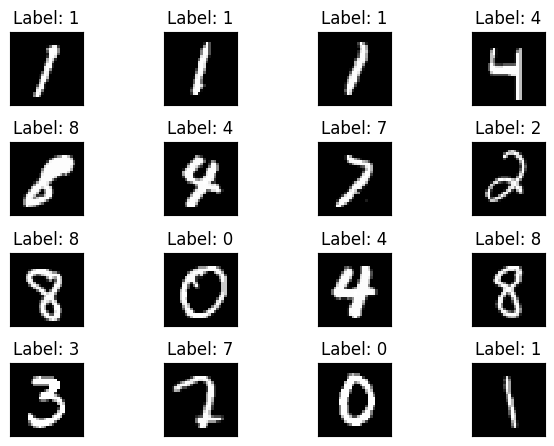

In [128]:

# Create a DataLoader object for the training set
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

# Get the first batch of images and labels from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot 16 images from the batch
fig = plt.figure()
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap="gray", interpolation="none")
    plt.title(f"Label: {labels[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()



In [129]:




# Create an instance of the Discriminator class and move it to the specified device
discriminator = Discriminator().to(device)



In [130]:

# Create an instance of the Generator class and move it to the specified device
generator = Generator().to(device)



In [131]:


# Set the learning rate and number of training epochs
lr = 0.0001
epochs = 10

# Define the loss function
loss_function = nn.BCELoss()

# Create optimizers for the discriminator and generator
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)


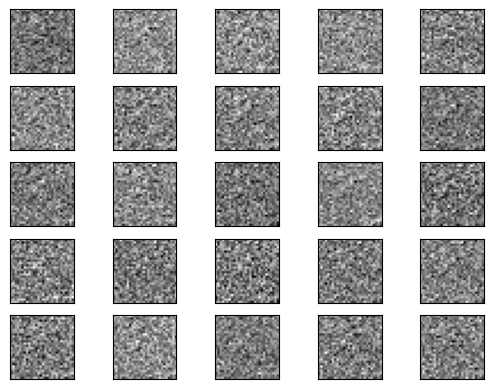

In [132]:


def test():
    # Generate random latent space samples
    latent_space_samples = torch.randn(batch_size, 100).to(device=device)
    # Generate fake samples using the generator
    generated_samples = generator(latent_space_samples)

    # Move the generated samples to the CPU and detach them from the computation graph
    generated_samples = generated_samples.cpu().detach()
    # Plot 25 of the generated samples
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        # Reshape the image to 28x28 and display it using a grayscale colormap
        # display.display(plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r"))
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        # Remove the x and y ticks from the plot
        plt.xticks([])
        plt.yticks([])
test()


In [133]:

import csv

def train_GAN_model(generator=generator, discriminator=discriminator, load_weights=False):
    total_training_time = 0
    # Load pre-trained weights for the generator and discriminator using pickle
    if load_weights:
        generator = pickle.load(open('generator.pkl', 'rb'))
        discriminator = pickle.load(open('discriminator.pkl', 'rb'))
        with open('losses.csv', 'r') as f:
            data = f.readlines() 
        lastRow = data[-1]
        last_epoch =  int(lastRow.split(",")[0])
    else:
        last_epoch = 0
        # Clear the CSV file if not loading pre-trained weights
        with open('losses.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'gen_loss', 'disc_loss'])
    for epoch in range(last_epoch,epochs+last_epoch):
        ETA = (epochs-epoch-1)*(total_training_time/(epoch+1))
        me, se = divmod(ETA, 60)
        he, me = divmod(me, 60)
        print(f"Epoch: {epoch+1}/{epochs}   ETA: {int(he):02d}:{int(me):02d}:{int(se):02d}")
        # Measure the start time
        start_time = time.time()
        for n, (real_samples, _) in enumerate(train_loader):
            # Show progress
            print(f"\rProgress: [{'# ' * int(20 * (n / len(train_loader)))}{'__' * (20 - int(20 * (n / len(train_loader))))}] {int(100 * (n / len(train_loader)))}%", end="")
            # Move the data to the specified device
            real_samples = real_samples.to(device=device)
            # Create labels for the real samples (all ones)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            # Generate random latent space samples
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            # Generate fake samples using the generator
            generated_samples = generator(latent_space_samples)
            # Create labels for the generated samples (all zeros)
            generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
            # Concatenate the real and generated samples and their labels
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

            # Train the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            discriminator_optimizer.step()

            # Generate new random latent space samples
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

            # Train the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            generator_optimizer.step()

        # Measure the train time and compute the elapsed time
        end_time = time.time()
        elapsed_time = end_time - start_time
        total_training_time += elapsed_time
        m, s = divmod(elapsed_time, 60)
        h, m = divmod(m, 60)
        print(f"\rElapsed time: {int(h):02d}:{int(m):02d}:{int(s):02d}")

        # Print the losses
        print(f"\rLoss D.: {loss_discriminator} Loss G.: {loss_generator}")

        # Save the losses to the CSV file
        with open('losses.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1, loss_generator.item(), loss_discriminator.item()])

        # Save the trained weights for the generator and discriminator using pickle
        pickle.dump(generator, open('generator.pkl', 'wb'))
        pickle.dump(discriminator, open('discriminator.pkl', 'wb'))
    # Convert total training time to hours, minutes, and seconds
    m, s = divmod(total_training_time, 60)
    h, m = divmod(m, 60)
    print(f"\nTotal training time: {int(h):02d}:{int(m):02d}:{int(s):02d}")



In [134]:

# Train the model for the specified number of epochs
train_GAN_model(load_weights=False)


Epoch: 1/10   ETA: 00:00:00
Elapsed time: 00:01:22 # # # # # # # # # # # # # __] 99%
Loss D.: 0.1397179812192917 Loss G.: 2.845891237258911
Epoch: 2/10   ETA: 00:05:31
Elapsed time: 00:01:21 # # # # # # # # # # # # # __] 99%
Loss D.: 0.11498802155256271 Loss G.: 3.7684378623962402
Epoch: 3/10   ETA: 00:06:24
Elapsed time: 00:01:26 # # # # # # # # # # # # # __] 99%
Loss D.: 0.3728637993335724 Loss G.: 2.496516704559326
Epoch: 4/10   ETA: 00:06:16
Elapsed time: 00:01:15 # # # # # # # # # # # # # __] 99%
Loss D.: 0.240589439868927 Loss G.: 2.5588912963867188
Epoch: 5/10   ETA: 00:05:26
Elapsed time: 00:01:02 # # # # # # # # # # # # # __] 99%
Loss D.: 0.4143037497997284 Loss G.: 1.804213523864746
Epoch: 6/10   ETA: 00:04:19
Progress: [# # # # # # # # # # ____________________] 53%

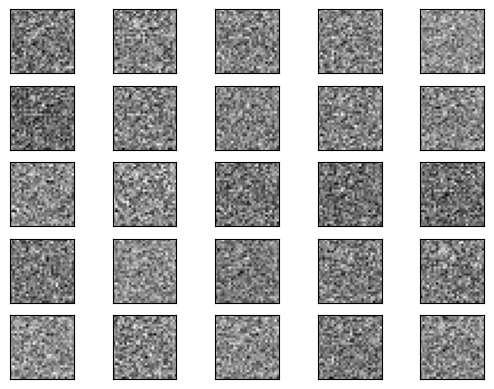

In [ ]:

test()
